## Subspaces <> Language

In these experiments, we aim to map concept descriptions to subspace representations. Our goal is to find a model that generates representations corresponding to the concept descriptions.

#### Set-ups

In [1]:
import torch, json, random, einops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
import matplotlib.pyplot as plt

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
def load_jsonl(jsonl_path):
    """
    Load data from a JSON lines file.
    """
    jsonl_data = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            jsonl_data += [data]
    return jsonl_data

def get_logits(model, tokenizer, concept_subspace, k=10):
    top_logits, neg_logits = [None], [None]

    W_U = model.lm_head.weight.T
    W_U = W_U * (model.model.norm.weight +
                torch.ones_like(model.model.norm.weight))[:, None]
    W_U -= einops.reduce(
        W_U, "d_model d_vocab -> 1 d_vocab", "mean"
    )

    vocab_logits = concept_subspace @ W_U
    top_values, top_indices = vocab_logits.topk(k=k, sorted=True)
    top_tokens = tokenizer.batch_decode(top_indices.unsqueeze(dim=-1))
    top_logits = [list(zip(top_tokens, top_values.tolist()))]
    
    neg_values, neg_indices = vocab_logits.topk(k=k, largest=False, sorted=True)
    neg_tokens = tokenizer.batch_decode(neg_indices.unsqueeze(dim=-1))
    neg_logits = [list(zip(neg_tokens, neg_values.tolist()))]

    return top_logits, neg_logits

class MyDataset(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
        
    def __len__(self):
        return len(self.x_list)
    
    def __getitem__(self, idx):
        return self.x_list[idx], self.y_list[idx]

def my_collate_fn(batch):
    x_texts, y_tensors = zip(*batch)
    encodings = tokenizer(
        list(x_texts),
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )
    y_tensors = torch.stack(y_tensors, dim=0)
    return encodings, y_tensors

class RegressionWrapper(nn.Module):
    def __init__(self, base_model, hidden_size, output_dim):
        super().__init__()
        self.base_model = base_model
        self.regression_head = nn.Linear(hidden_size, output_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model.base_model(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
        last_hiddens = outputs.hidden_states[-1]
        last_token_indices = attention_mask.sum(dim=1) - 1
        last_token_representations = last_hiddens[torch.arange(last_hiddens.shape[0]), last_token_indices]
        preds = self.regression_head(last_token_representations)  # shape: [batch_size, output_dim]
        preds = F.normalize(preds, p=2, dim=1)
        return preds

In [3]:
lsreft = torch.load("../results/prod_2b_l20_concept16k_lsreft/train/LsReFT_weight.pt")
lsreft_metadata = load_jsonl("../results/prod_2b_l20_concept16k_lsreft/train/metadata.jsonl")
assert lsreft.shape[0] == len(lsreft_metadata)

#### Unembed learned subspace

We can follow unembed the learned subspace to output tokens, and get top ranked tokens that are related to the learned subspace.

In [4]:
# Load the interpreting model
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b-it", torch_dtype=torch.bfloat16)
_ = model.cuda()
tokenizer = AutoTokenizer.from_pretrained(
    "google/gemma-2-2b-it", model_max_length=512)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# Get a random subspace and its label
concept_id = random.randint(0, lsreft.shape[0] - 1)
concept_id

340

In [6]:
concept_subspace = lsreft[concept_id].cuda()
print("Concept:", lsreft_metadata[concept_id]["concept"])

Concept: occurrences of the term "Mar" followed by relevant numerical and descriptive modifiers


In [7]:
get_logits(model, tokenizer, concept_subspace, k=5)

([[(' occurrences', 1.15625),
   ('Mar', 1.0390625),
   (' occurring', 1.0234375),
   (' Mar', 1.0078125),
   (' Notably', 0.98828125)]],
 [[('asiest', -0.57421875),
   (' lät', -0.5546875),
   ('principalTable', -0.55078125),
   ('principle', -0.53125),
   (' biß', -0.50390625)]])

Nice! We are at least getting interpretable tokens that are closely related to the concept!

#### Training to map concept to subspace via learning

Let's first create some training / validation dataset:
```
input  : concept described in natural language
output : concept subspace
```

In [8]:
x = [md["concept"] for md in lsreft_metadata]
y = [lsreft[i] for i in range(lsreft.shape[0])]

x_train, x_test = x[:-1000], x[-1000:]
y_train, y_test = y[:-1000], y[-1000:]

train_dataset = MyDataset(x_train, y_train)
val_dataset   = MyDataset(x_test, y_test)
train_loader  = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=my_collate_fn)
val_loader    = DataLoader(val_dataset,   batch_size=128, shuffle=False, collate_fn=my_collate_fn)

We will finetune our language model to predict `y` from `x`

In [9]:
# Load the interpreting model
base_model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b-it", torch_dtype=torch.bfloat16)
_ = base_model.cuda()
tokenizer = AutoTokenizer.from_pretrained(
    "google/gemma-2-2b-it", model_max_length=512)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
hidden_size = base_model.config.hidden_size
output_dim = y_train[0].shape[-1]
subspace_gen = RegressionWrapper(base_model, hidden_size, output_dim).bfloat16().to("cuda")

epochs = 24
learning_rate = 8e-2

optimizer = AdamW(subspace_gen.parameters(), lr=learning_rate, weight_decay=0.0)
mse_criterion = nn.MSELoss(reduction="none")
cos_criterion = nn.CosineEmbeddingLoss(reduction="none")

num_training_steps = epochs * len(train_loader)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [28]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    subspace_gen.train()
    epoch_train_loss = 0.0
    
    # Wrap your dataloader with tqdm so you get a progress bar
    pbar = tqdm(train_loader, 
                total=len(train_loader), 
                desc=f"Epoch {epoch+1}/{epochs}", 
                leave=False)

    for batch_idx, (encodings, y_true) in enumerate(pbar):
        input_ids = encodings["input_ids"].to("cuda")
        attention_mask = encodings["attention_mask"].to("cuda")
        y_true = y_true.to("cuda")

        optimizer.zero_grad()
        
        # Forward pass
        y_pred = subspace_gen(input_ids, attention_mask)
        
        # Compute loss
        mse_loss = mse_criterion(y_pred, y_true) 
        mse_loss = mse_loss.sum(dim=-1).mean()
        similarity = F.cosine_similarity(y_pred, y_true, dim=-1)  # shape: [batch_size]
        cos_loss = 1.0 - similarity.mean()
        loss = mse_loss + cos_loss
        
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        # Accumulate training loss
        epoch_train_loss += loss.item()
        
        # Update tqdm progress bar with current loss
        pbar.set_postfix({"train_loss": f"{loss.item():.4f}"})

    # Average training loss for the epoch
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    subspace_gen.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for encodings, y_true in val_loader:
            input_ids = encodings["input_ids"].to("cuda")
            attention_mask = encodings["attention_mask"].to("cuda")
            y_true = y_true.to("cuda")
            
            y_pred = subspace_gen(input_ids, attention_mask)
            
            mse_loss = mse_criterion(y_pred, y_true) 
            mse_loss = mse_loss.sum(dim=-1).mean()
            similarity = F.cosine_similarity(y_pred, y_true, dim=-1)  # shape: [batch_size]
            cos_loss = 1.0 - similarity.mean()
            loss = mse_loss + cos_loss
        
            epoch_val_loss += loss.item()
    
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

Epoch [1/24] | Train Loss: 1.6170 | Val Loss: 1.4902


Epoch [2/24] | Train Loss: 1.4899 | Val Loss: 1.4922


Epoch [3/24] | Train Loss: 1.4892 | Val Loss: 1.4863


Epoch [4/24] | Train Loss: 1.4879 | Val Loss: 1.4863


Epoch [5/24] | Train Loss: 1.4864 | Val Loss: 1.4854


Epoch [6/24] | Train Loss: 1.4718 | Val Loss: 1.5068


Epoch [7/24] | Train Loss: 1.4563 | Val Loss: 1.4766


Epoch [8/24] | Train Loss: 1.4596 | Val Loss: 1.4619


Epoch [9/24] | Train Loss: 1.4267 | Val Loss: 1.3730


Epoch [10/24] | Train Loss: 1.4095 | Val Loss: 1.4023


Epoch [11/24] | Train Loss: 1.3821 | Val Loss: 1.3584


Epoch [12/24] | Train Loss: 1.3218 | Val Loss: 1.3359


Epoch [13/24] | Train Loss: 1.3087 | Val Loss: 1.3408


Epoch [14/24] | Train Loss: 1.3037 | Val Loss: 1.3223


Epoch [15/24] | Train Loss: 1.2841 | Val Loss: 1.3262


Epoch [16/24] | Train Loss: 1.2954 | Val Loss: 1.3115


Epoch [17/24] | Train Loss: 1.2693 | Val Loss: 1.3037


Epoch [18/24] | Train Loss: 1.2664 | Val Loss: 1.3047


Epoch [19/24] | Train Loss: 1.2558 | Val Loss: 1.2920


Epoch [20/24] | Train Loss: 1.2555 | Val Loss: 1.2959


Epoch [21/24] | Train Loss: 1.2516 | Val Loss: 1.2910


Epoch [22/24] | Train Loss: 1.2492 | Val Loss: 1.2861


Epoch [23/24] | Train Loss: 1.2492 | Val Loss: 1.2871


Epoch [24/24] | Train Loss: 1.2523 | Val Loss: 1.2861


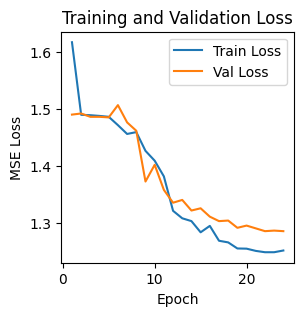

In [30]:
plt.figure(figsize=(3,3))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### Inference with mapping new concept to subspace

The training loss looks great! Let's now test with new concepts.

In [31]:
your_new_concept = "references to rental services and associated equipment"

In [32]:
subspace_gen.eval()
model.eval()
inputs = tokenizer(your_new_concept, return_tensors="pt").to("cuda")
input_ids, attention_mask = inputs["input_ids"], inputs["attention_mask"]
your_subspace = subspace_gen(input_ids, attention_mask)[0]

In [33]:
get_logits(model, tokenizer, your_subspace, k=10)

([[(' akin', 1.0078125),
   (' reminiscent', 0.8515625),
   (' wherein', 0.8125),
   ('wherein', 0.75390625),
   (" '/';", 0.75),
   ('.},', 0.74609375),
   (' analogous', 0.73828125),
   (' amid', 0.72265625),
   (' –,', 0.71484375),
   ('듯', 0.70703125)]],
 [[(' pretty', -0.71484375),
   ('asiest', -0.6953125),
   (' stupidly', -0.67578125),
   (' montón', -0.64453125),
   (' REALLY', -0.64453125),
   (' crappy', -0.63671875),
   (' honte', -0.63671875),
   (' opinião', -0.62890625),
   (' stupid', -0.609375),
   (' wierd', -0.609375)]])